In [2]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import json

# import a lot of things from keras:
# sequential model
from keras.models import load_model

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# include only those gestures
CONDITIONS = ['like', 'dislike', 'stop', 'rock', 'peace']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

In [3]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

In [4]:
annotations = dict()

with open(f'annot-dobiosz.json') as f:
    annotations = json.load(f)

In [5]:
# pretty-print first element
print(json.dumps(annotations['like1'], indent=2))

{
  "bboxes": [
    [
      0.325,
      0.371875,
      0.24444444444444444,
      0.0703125
    ],
    [
      0.11203703703703703,
      0.8203125,
      0.25092592592592594,
      0.17083333333333334
    ]
  ],
  "labels": [
    "like",
    "no_gesture"
  ]
}


In [6]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists

for filename in tqdm(os.listdir(f'images')):
    # extract unique ID from file name
    UID = filename.split('.')[0]
    img = cv2.imread(f'images/{filename}')
    
    # get annotation from the dict we loaded earlier
    try:
        annotation = annotations[UID]
    except Exception as e:
        print(e)
        continue
    
    # iterate over all hands annotated in the image
    for i, bbox in enumerate(annotation['bboxes']):
        # annotated bounding boxes are in the range from 0 to 1
        # therefore we have to scale them to the image size
        x1 = int(bbox[0] * img.shape[1])
        y1 = int(bbox[1] * img.shape[0])
        w = int(bbox[2] * img.shape[1])
        h = int(bbox[3] * img.shape[0])
        x2 = x1 + w
        y2 = y1 + h
        
        # crop image to the bounding box and apply pre-processing
        crop = img[y1:y2, x1:x2]

        preprocessed = preprocess_image(crop)
        
        # get the annotated hand's label
        # if we have not seen this label yet, add it to the list of labels
        label = annotation['labels'][i]
        if label not in label_names:
            label_names.append(label)
        
        label_index = label_names.index(label)
        
        images.append(preprocessed)
        labels.append(label_index)

  0%|          | 0/15 [00:00<?, ?it/s]

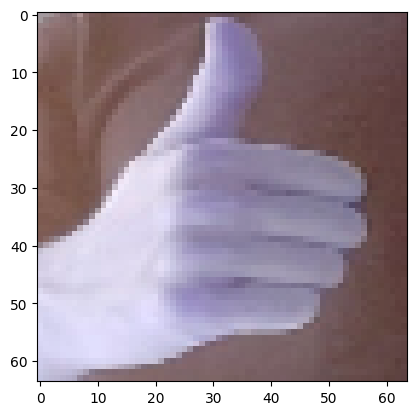

In [42]:
plt.imshow(images[8])

In [43]:
images = np.array(images).astype('float32')
new_images = images / 255.

new_images = images.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

1/1 [==============================] - 0s 337ms/step


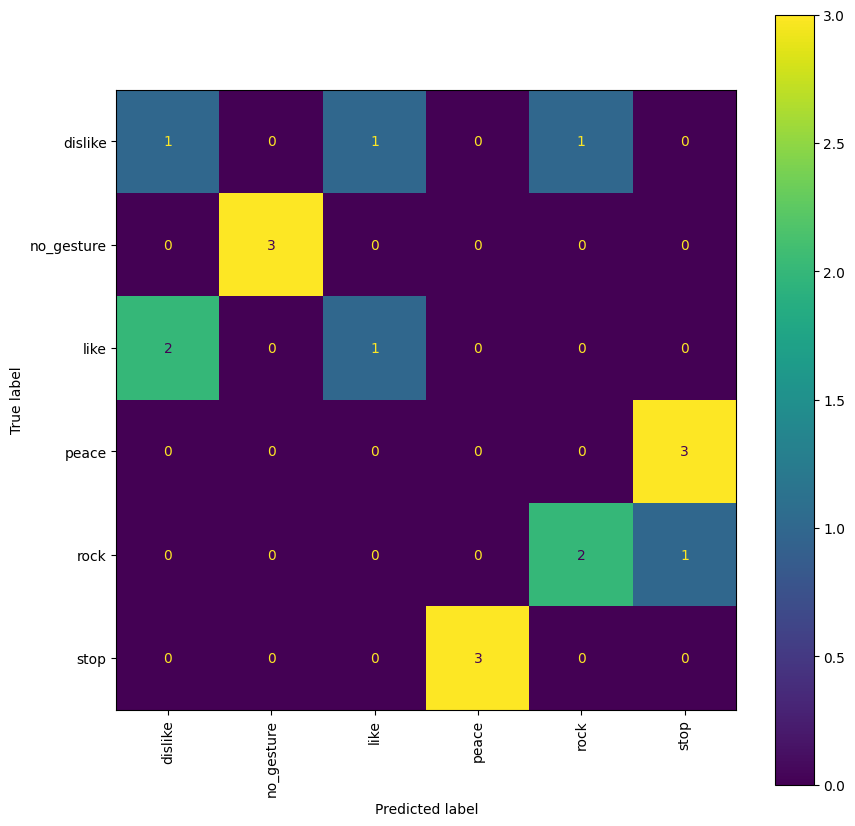

In [44]:
# load pretrained model
pretrained_model = load_model('pretrained_model')

# let the model make predictions for our training data
y_predictions = pretrained_model.predict(new_images)

# we get a 2D numpy array with probabilities for each category
#print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

#print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass